In [56]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [57]:
stock_price = pd.read_csv("C:\\Users\\unati\\Downloads\\bsesn.csv")
stock_headlines = pd.read_csv("C:\\Users\\unati\\Downloads\\india-news-headlines.csv")

In [58]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


In [59]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [60]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(252, 3650970)

In [61]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [62]:
#Numerical Stock Data
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0
...,...,...,...,...,...
2020-12-11,46099.011719,46060.320313,46309.628906,45706.218750,26300.0
2020-12-14,46253.460938,46284.699219,46373.339844,45951.531250,18400.0
2020-12-15,46263.171875,46287.390625,46350.300781,45841.671875,16400.0


In [63]:
#Textual News Headlines Data
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines


,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


In [64]:
#Combine Stock Data
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...
...,...,...,...,...,...,...
2020-12-11,46099.011719,46060.320313,46309.628906,45706.218750,26300.0,Ways to get you in the mood for sex when you'r...
2020-12-14,46253.460938,46284.699219,46373.339844,45951.531250,18400.0,"No threat from Covid claims to balance sheets,..."
2020-12-15,46263.171875,46287.390625,46350.300781,45841.671875,16400.0,1;147 RT-PCR tests in a day; only 3 found +ve ...
2020-12-16,46666.460938,46573.308594,46704.968750,46402.199219,13100.0,Asmita Sood's favourite holiday destinations a...


In [65]:
#alternate way is to use merge funtion and inner join operation 
pd.merge(stock_price, stock_headlines, left_index=True, right_index=True, how='inner')

,Close,Open,High,Low,Volume,headline_text
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...
...,...,...,...,...,...,...
2020-12-11,46099.011719,46060.320313,46309.628906,45706.218750,26300.0,Ways to get you in the mood for sex when you'r...
2020-12-14,46253.460938,46284.699219,46373.339844,45951.531250,18400.0,"No threat from Covid claims to balance sheets,..."
2020-12-15,46263.171875,46287.390625,46350.300781,45841.671875,16400.0,1;147 RT-PCR tests in a day; only 3 found +ve ...
2020-12-16,46666.460938,46573.308594,46704.968750,46402.199219,13100.0,Asmita Sood's favourite holiday destinations a...


In [66]:
#Sentiment Analysis
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...,,,,
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...,,,,
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...,,,,
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...,,,,
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...,,,,


In [67]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...,-1.0000,0.178,0.748,0.074
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...,-0.9999,0.146,0.782,0.072
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...,-0.9997,0.110,0.833,0.057
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...,-0.9999,0.157,0.769,0.074
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...,-0.9997,0.131,0.788,0.081


In [68]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# set the index name
stock_data.index.name = 'Date'

# displaying the final stock_data
stock_data.head()


,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2019-12-17,41352.171875,-1.0000,0.178,0.748,0.074,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,-0.9999,0.146,0.782,0.072,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9997,0.110,0.833,0.057,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,0.157,0.769,0.074,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9997,0.131,0.788,0.081,41548.261719,41701.621094,41474.609375,6200.0


In [69]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

In [70]:
stock_data.shape
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [71]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37745.454117,-0.991426,0.128724,0.794076,0.077160,37804.237375,38071.182859,37422.826992,19134.000000
std,4535.304336,0.126305,0.020739,0.025585,0.012089,4507.985769,4380.974060,4647.212947,16540.261333
min,25981.240234,-1.000000,0.076000,0.728000,0.046000,26499.810547,27462.869141,25638.900391,0.000000
25%,34257.097656,-0.999900,0.115000,0.776000,0.069000,34369.659179,34779.932618,33975.389648,13125.000000
50%,38425.974610,-0.999750,0.128000,0.791000,0.077000,38489.480469,38750.359375,38234.869140,17000.000000
75%,41135.233399,-0.999500,0.141000,0.812000,0.085000,41179.222656,41376.482422,41023.923828,21075.000000
max,46890.339844,0.997400,0.199000,0.867000,0.127000,46774.320313,46992.570313,46627.601563,188300.000000


In [72]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2019-12-17 to 2020-12-17
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     250 non-null    float64
 1   compound  250 non-null    float64
 2   negative  250 non-null    float64
 3   neutral   250 non-null    float64
 4   positive  250 non-null    float64
 5   Open      250 non-null    float64
 6   High      250 non-null    float64
 7   Low       250 non-null    float64
 8   Volume    250 non-null    float64
dtypes: float64(9)
memory usage: 19.5 KB


Text(0, 0.5, 'Close Price ($)')

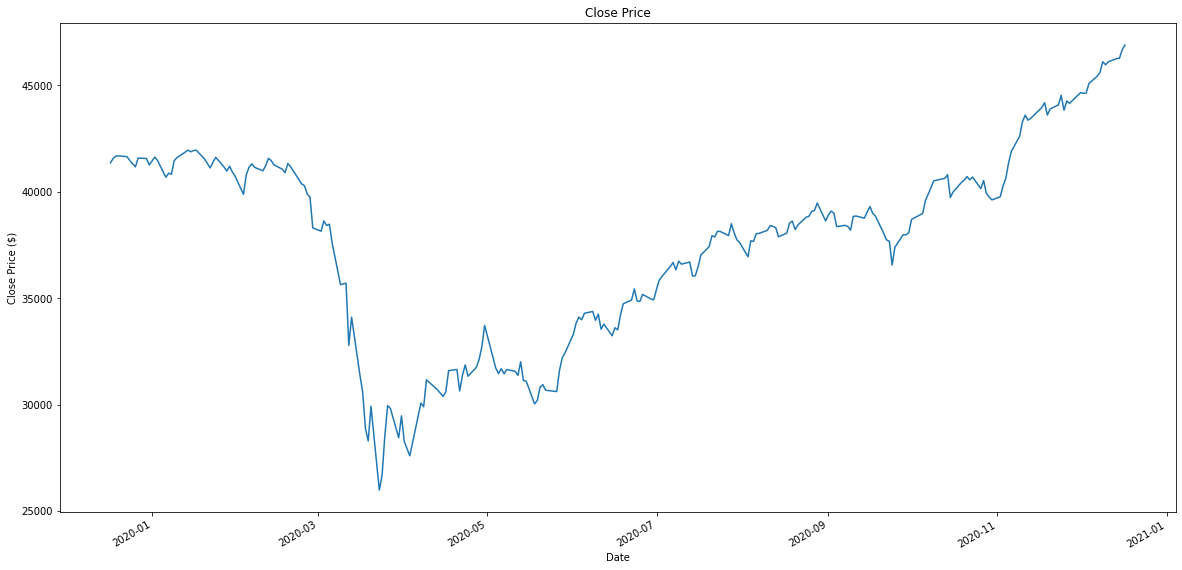

In [73]:
# setting figure size
plt.figure(figsize=(20,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [74]:
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2019-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,41504.840960,-0.999857,0.144714,0.781143,0.074143,41512.814732,41642.010045,41355.246652,18057.142857
2019-12-27,41536.693639,-0.999843,0.144000,0.782286,0.073714,41547.774554,41671.955915,41392.352679,16214.285714
2019-12-30,41536.612165,-0.999843,0.147429,0.778429,0.074286,41582.563058,41686.236049,41405.911272,13557.142857


<AxesSubplot:xlabel='Date'>

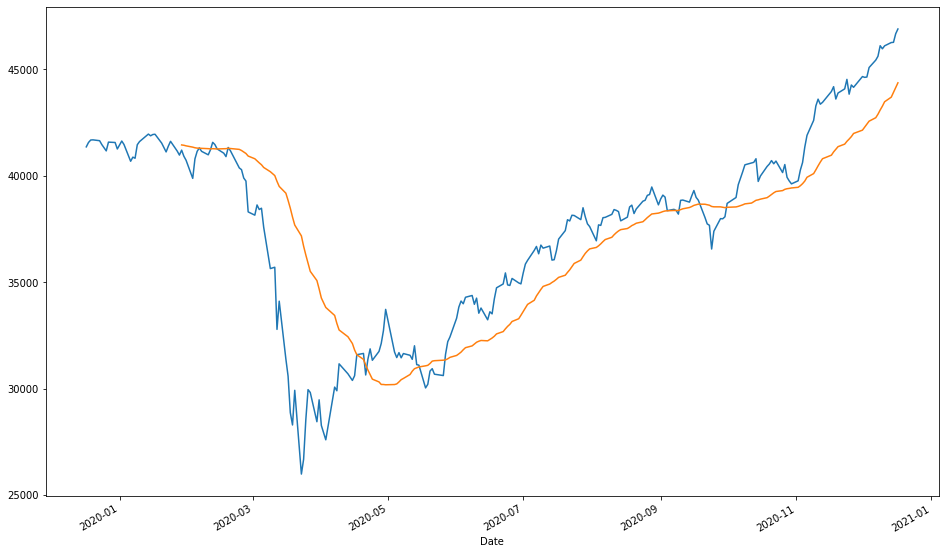

In [75]:

# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [76]:
#Data Preparation
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 199
Number of records in Test Data: 51


In [77]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2019-12-18    41558.570313
2019-12-19    41673.921875
2019-12-20    41681.539063
2019-12-23    41642.660156
2019-12-24    41461.261719
                  ...     
2020-12-11    46099.011719
2020-12-14    46253.460938
2020-12-15    46263.171875
2020-12-16    46666.460938
2020-12-17    46890.339844
Name: Close, Length: 249, dtype: float64

In [78]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2019-12-18,41558.570313,41673.921875,-0.9999,-0.9997,24300.0,41442.750000,41614.769531,41358.468750
2019-12-19,41673.921875,41681.539063,-0.9997,-0.9999,33300.0,41571.820313,41719.289063,41456.398438
2019-12-20,41681.539063,41642.660156,-0.9999,-0.9997,33600.0,41746.199219,41809.960938,41636.109375
2019-12-23,41642.660156,41461.261719,-0.9997,-0.9999,6200.0,41548.261719,41701.621094,41474.609375
2019-12-24,41461.261719,41163.761719,-0.9999,-0.9999,4400.0,41684.511719,41702.980469,41423.070313
2019-12-26,41163.761719,41575.140625,-0.9999,-0.9999,5600.0,41543.800781,41543.800781,41132.890625
2019-12-27,41575.140625,41558.000000,-0.9999,-0.9999,6100.0,41297.078125,41611.269531,41264.921875
2019-12-30,41558.000000,41253.738281,-0.9999,-0.9999,5700.0,41686.269531,41714.730469,41453.378906
2019-12-31,41253.738281,41626.640625,-0.9999,-0.9997,5600.0,41607.488281,41607.488281,41184.730469


In [79]:
#Setting Target Variable And Feature Dataset
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2019-12-18    41673.921875
2019-12-19    41681.539063
2019-12-20    41642.660156
2019-12-23    41461.261719
2019-12-24    41163.761719
                  ...     
2020-12-10    46099.011719
2020-12-11    46253.460938
2020-12-14    46263.171875
2020-12-15    46666.460938
2020-12-16    46890.339844
Name: close_price_shifted, Length: 248, dtype: float64

In [80]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2019-12-18,41558.570313,-0.9999,-0.9997,24300.0,41442.750000,41614.769531,41358.468750
2019-12-19,41673.921875,-0.9997,-0.9999,33300.0,41571.820313,41719.289063,41456.398438
2019-12-20,41681.539063,-0.9999,-0.9997,33600.0,41746.199219,41809.960938,41636.109375
2019-12-23,41642.660156,-0.9997,-0.9999,6200.0,41548.261719,41701.621094,41474.609375
2019-12-24,41461.261719,-0.9999,-0.9999,4400.0,41684.511719,41702.980469,41423.070313
...,...,...,...,...,...,...,...
2020-12-10,45959.878906,-0.9996,-0.9999,12700.0,45999.421875,46043.968750,45685.871094
2020-12-11,46099.011719,-0.9999,-0.9993,26300.0,46060.320313,46309.628906,45706.218750
2020-12-14,46253.460938,-0.9993,-0.9998,18400.0,46284.699219,46373.339844,45951.531250


In [81]:
#Scaling the Target Variable and the Feature Dataset
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 0.50613139, -0.99989987, -0.99969961, ...,  0.48882267,
          0.470931  ,  0.51416868],
        [ 0.51728443, -0.99969961, -0.99989987, ...,  0.50168244,
          0.48179463,  0.52360164],
        [ 0.51802091, -0.99989987, -0.99969961, ...,  0.51905648,
          0.49121895,  0.54091208],
        ...,
        [ 0.96006811, -0.99929909, -0.99979974, ...,  0.97124474,
          0.9655309 ,  0.95658995],
        [ 0.96100703, -0.99979974, -0.99939922, ...,  0.97151289,
          0.96313625,  0.94600787],
        [ 1.        , -0.99939922, -0.99969961, ...,  1.        ,
          1.        ,  1.        ]]),
 array([[ 0.50103849],
        [ 0.50176709],
        [ 0.49804824],
        [ 0.48069709],
        [ 0.45224058],
        [ 0.49158985],
        [ 0.48995031],
        [ 0.46084703],
        [ 0.49651594],
        [ 0.4810173 ],
        [ 0.40564529],
        [ 0.42409083],
        [ 0.4191427 ],
        [ 0.47984482],
        [ 0.4939408 ],
        [ 0.51880774],
     

In [82]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (199, 7) and y: (199, 1)
Number of rows and columns in the Test set X: (48, 7) and y: (48, 1)


In [83]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (199, 7, 1)
Shape of Test set X: (48, 7, 1)


In [84]:
#Stock data modelling
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 100)            40800     
                                                                 
 dropout_3 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_4 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [85]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
20/20 [==============================] - 6s 69ms/step - loss: 0.1431 - val_loss: 0.0831
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0378 - val_loss: 0.0023
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0183 - val_loss: 0.0030
Epoch 4/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0115 - val_loss: 0.0019
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0018
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0097 - val_loss: 0.0022
Epoch 7/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0101 - val_loss: 0.0024
Epoch 8/10
20/20 [==============================] - 1s 30ms/step - loss: 0.0103 - val_loss: 0.0130
Epoch 9/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0120 - val_loss: 0.0019
Epoch 10/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0101 - val_loss: 0.0030


In [86]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
20/20 [==============================] - 6s 71ms/step - loss: 0.0177 - val_loss: 0.0042
Epoch 2/10
20/20 [==============================] - 1s 42ms/step - loss: 0.0133 - val_loss: 0.0061
Epoch 3/10
20/20 [==============================] - 1s 25ms/step - loss: 0.0096 - val_loss: 0.0019
Epoch 4/10
20/20 [==============================] - 0s 19ms/step - loss: 0.0080 - val_loss: 0.0040
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0097 - val_loss: 0.0028
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 9/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 10/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0076 - val_loss: 0.0028


In [87]:
#Model prediction
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

2/2 [==============================] - 1s 6ms/step
Predictions:


array([[39953.883],
       [40290.855],
       [40500.203],
       [40317.02 ],
       [40572.98 ]], dtype=float32)

In [88]:
#Model Evalution
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

48/48 [==============================] - 0s 4ms/step - loss: 0.0395
Train Loss = 0.0064
Test Loss = 0.0395


In [89]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 43315.7587


In [90]:

# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 43315.7587


In [91]:
#Plotting the Predictions against unseen data
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

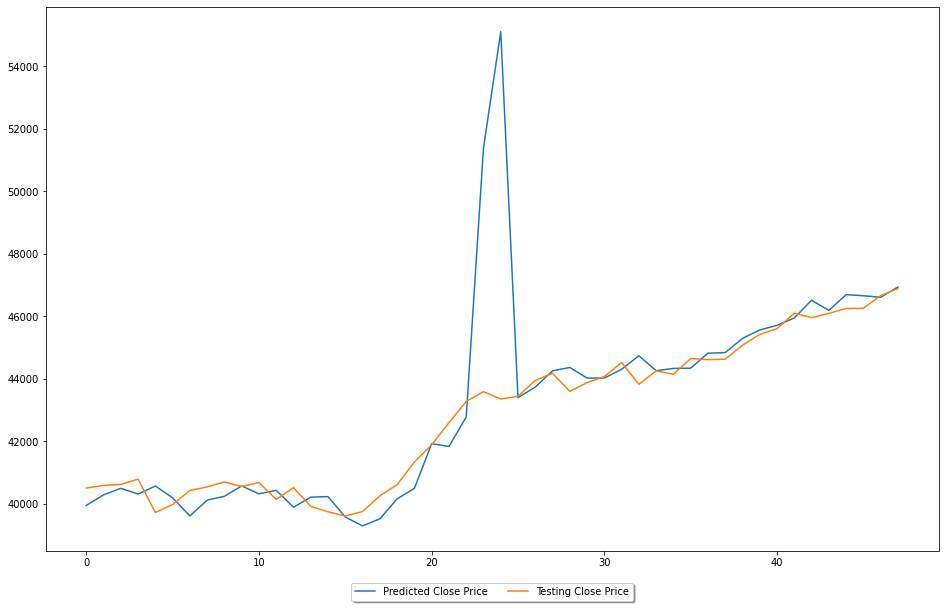

In [92]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()